# Ferret data
In this notebook, we replicate the results of Macke et al. (2011).
First, we load the imaging data. Its size is (npixels_x, npixels_y, conditions, trials).

In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from opm import calculate_map, plot_opm, plot_amplitude_map
from opm.response import create_stimuli, compute_responses
from opm.covariance import avg_neighbor_corr

seed = 134
np.random.seed(seed)

data = scipy.io.loadmat('data/ferretdata.mat')
data = data['dat'] # data is stored in a dict
data.shape

(126, 252, 8, 100)

Reshape the data to (conditions, trials, npixels_x, npixels_y) and split the data into one part used as "ground truth" (95%) and one part used for inference (5%).

In [2]:
R = np.transpose(data[26:,:200,:,:], (2,3,0,1))

# take only a small part of the image (for performance reasons)
#R = R[:,:,38:58,106:136]

# downsample image
#R = R[:,:,::2,::2]

size = R.shape[2:]
n = size[0] * size[1]
N = R.shape[0] * R.shape[1]
R.shape

(8, 100, 100, 200)

## Plot responses
Visualize the responses for the small patch

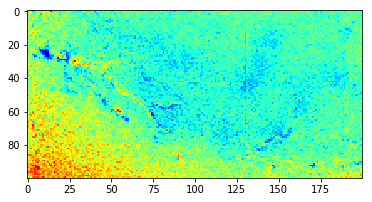

In [3]:
plt.imshow(R[0,np.random.randint(5),:,:], cmap='jet')
plt.show()

## Maximum likelihood solution
Compute the solution using vector averaging (for details see OPM.ipynb)

In [4]:
angles = [i * np.pi / 4 for i in range(4)]*2

V = create_stimuli([1.], angles, 100)
d = V.shape[2]
V.shape

(8, 100, 3)

In [5]:
#m_gt = calculate_map(R_gt, create_stimuli([1.], angles, 95))
#m_gt = m_gt[0] + 1j * m_gt[1]

m_hat = calculate_map(R, V)

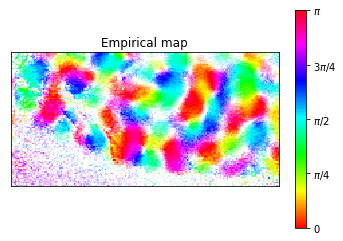

In [6]:
#plot_opm(m_gt, pinwheels=False, shade=True, rmax=80, title='Ground truth')
#plt.show()

plot_opm(m_hat[0] + 1j * m_hat[1], pinwheels=False, shade=True, rmax=80, title='Empirical map')
plt.show()

## Noise covariance structure
We now examine the structure of the covariance of the residuals

$$ \mathbf{z}_i = \mathbf{r}_i - V_i^T \mathbf{\hat{m}} $$

In [7]:
z = R.reshape(N, n) - V.reshape(N, d) @ m_hat.reshape(d, n)
cov = np.cov(z.T)

In order to compare the observed noise pattern to the assumption of i.i.d. noise, we simulate responses with i.i.d. noise given the empirical map and then compute their variances.

In [8]:
R_iso = compute_responses(m_hat[0] + 1j * m_hat[1], [1.], angles, 100, sigma=np.mean(np.sqrt(np.diag(cov))))

z_iso = R_iso.reshape(N, n) - V.reshape(N, d) @ m_hat.reshape(d, n)
cov_iso = np.cov(z_iso.T)

We first visualize the noise variances (i.e. the diagonal of the covariance matrix). As we can see, there are obvious differences in the noise variances across the map. If the noise variance was constant across the map, 99% of the variances would fall between the two gray bars in the histogram. The spread is much bigger for the actual noise pattern.




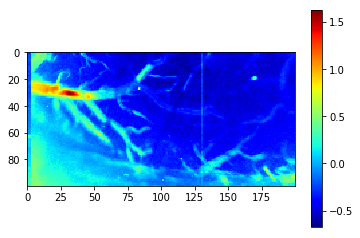

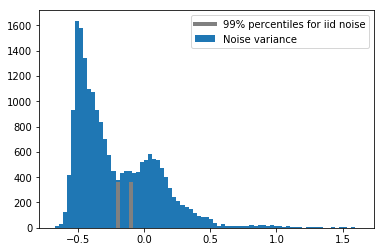

In [9]:
plt.imshow(np.log10(np.diag(cov)).reshape(*R.shape[2:]), cmap='jet')
plt.colorbar()
plt.show()

f, ax = plt.subplots()
ax.hist(np.log10(np.diag(cov)), bins=75, edgecolor='none', label='Noise variance')

for i, p in enumerate(np.percentile(np.log10(np.diag(cov_iso)), [1, 99])):
    ax.axvline(x=p, ymin=0, ymax=0.2, color='gray', linewidth=4, label='99% percentiles for iid noise' if i==1 else None)
ax.legend()
plt.show()

The plot below shows the noise covariances of each pixel with all neighboring pixels within a radius of 2 pixels. The noise is strongly correlated as shown by the histogram. The correlations are highest at the blood vessels.

In [10]:
nbcorr = avg_neighbor_corr(cov, size=size, radius=2)

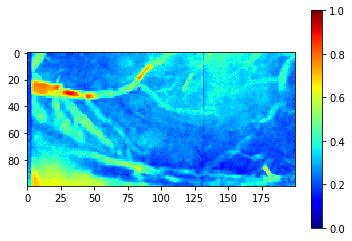

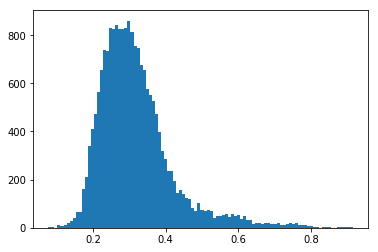

In [11]:
plt.imshow(nbcorr, cmap='jet', vmin=0, vmax=1)
plt.colorbar()
plt.show()

plt.hist(nbcorr.reshape(-1), bins=100)
plt.show()

## Estimate map from little data

We now take the right square region of the rectangular patch above and try to compute a smooth estimate. To estimate performance, we create a "ground truth" map from 95% of the data and use 5% of the data as data for inference.

In [12]:
# use 95% of the data as the "ground truth"
# and 5% of the data as real data
idx = np.array([False for i in range(100)])
idx[np.arange(100)[np.random.choice(100, size=5, replace=False)]] = True
R_gt = R[:,~idx,:,100:]
R_data = R[:,idx,:,100:]

V_data = create_stimuli([1.], angles, 5)

data_size = R_data.shape[2:]

In [23]:
N = R_data.shape[0] * R_data.shape[1]

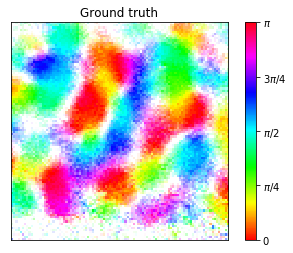

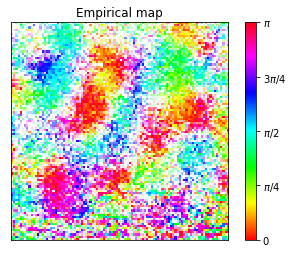

In [14]:
m_gt = calculate_map(R_gt, create_stimuli([1.], angles, 95))
#m_gt = m_gt[0] + 1j * m_gt[1]
plot_opm(m_gt[0] + 1j * m_gt[1], pinwheels=False, shade=True, rmax=80, title='Ground truth')
plt.show()

m_data = calculate_map(R_data, V_data)
#m_data = m_data[0] + 1j * m_data[1]
plot_opm(m_data[0] + 1j * m_data[1], pinwheels=False, shade=True, rmax=80, title='Empirical map')
plt.show()

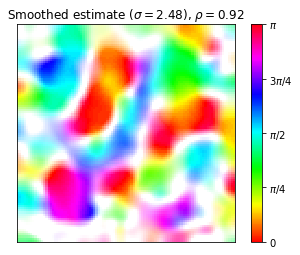

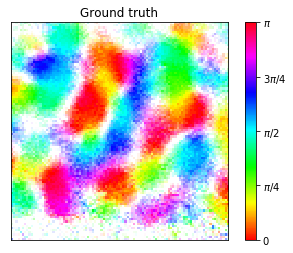

In [15]:
from scipy.ndimage import filters
import scipy.stats as ss

best_corr = -np.inf
best_sigma = np.nan
for sigma in 10**np.linspace(-2, 1, 100):
    
    # smoothe the estimate of the angle
    m_smooth = filters.gaussian_filter(m_data, sigma=(0, sigma, sigma))
    
    corr = ss.pearsonr(m_smooth[:2].reshape(-1), m_gt[:2].reshape(-1))[0]
    
    #plot_opm(m_smooth[0] + 1j * m_smooth[1], title=r'$\sigma = {0:.2f}$, $\rho = {1:.2f}$'.format(sigma, corr), pinwheels=False)
    #plt.show()
    
    if corr > best_corr:
        best_corr = corr
        best_sigma = sigma
        best_theta = m_smooth[0] + 1j * m_smooth[1]
        

plot_opm(best_theta, pinwheels=False, shade=True,
         title=r'Smoothed estimate ($\sigma = {0:.2f}$), $\rho = {1:.2f}$'.format(best_sigma, best_corr))
plt.show()


plot_opm(m_gt[0] + 1j * m_gt[1], title='Ground truth', pinwheels=False, shade=True)
plt.show()

## Gaussian Process method

We compare the Gaussian process method to the vector averaging appraoch.

In [16]:
from opm.gp import GaussianProcessOPM

In [66]:
gp = GaussianProcessOPM(size=data_size, prior_method='icd', prior_rank=1600)

In [67]:
mu_post = gp.fit(stimuli=V_data, responses=R_data, noise='factoran', verbose=True, noise_kwargs={'iterations':3, 'q':1})

Estimating prior hyperparameters:
{'sigma': 5.955136549181468, 'alpha': 5.115067527230201}
*** Fitting prior ***
Calculating the prior from scratch..
*** Fitting posterior ***
Fitting noise model: iteration 1
Fitting noise model: iteration 2
Fitting noise model: iteration 3


In [69]:
gp.save(fname='pkl/ferret_{}x{}px_{}trials_{}seed.pkl'.format(*data_size, N, seed))

In [27]:
gp = GaussianProcessOPM.load(fname='pkl/ferret_{}x{}px_{}trials_{}seed.pkl'.format(*data_size, N, seed))

In [28]:
#mu = m.reshape(3, size)
result = gp.mu_post[0] + 1j * gp.mu_post[1]

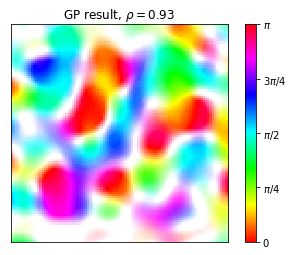

In [29]:
f, ax = plot_opm(result, shade=True, rmax=80, pinwheels=False,
                 title=r'GP result, $\rho = {:.2f}$'.format(ss.pearsonr(gp.mu_post[:2].reshape(-1), m_gt[:2].reshape(-1))[0]))
plt.show()

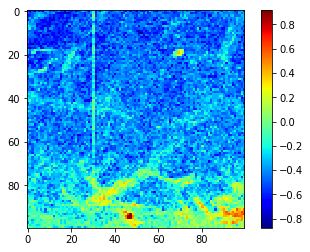

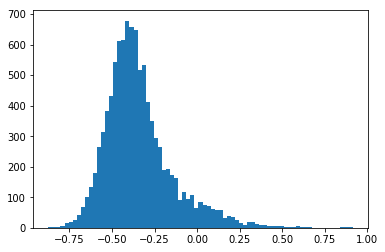

In [30]:
noise_var = np.diag(gp.noise.covariance)

plt.imshow(np.log10(noise_var).reshape(*data_size), cmap='jet')
plt.colorbar()
plt.show()

f, ax = plt.subplots()
ax.hist(np.log10(noise_var), bins=75, edgecolor='none', label='Noise variance')
plt.show()

In [31]:
corr_neighbor = avg_neighbor_corr(gp.noise.covariance, data_size, radius=2)

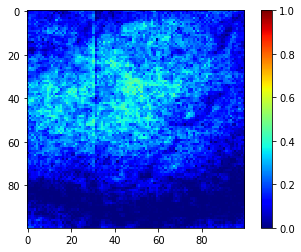

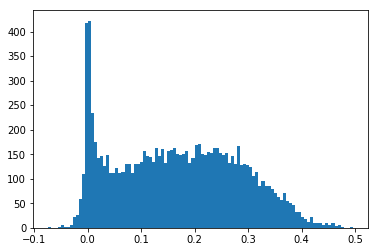

In [32]:
plt.imshow(corr_neighbor, cmap='jet', vmin=0, vmax=1)
plt.colorbar()
plt.show()

plt.hist(corr_neighbor.reshape(-1), bins=100)
plt.show()